In [1]:
import numpy as np 
import os 
import datetime
import celerite
import numpy as np
import matplotlib.pyplot as plt
from celerite import terms
from scipy.optimize import minimize
from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

 MacLeod+2010  talks about ACF for DRW model being 

  $ACF(\Delta t) = \exp(-|\Delta  t|/\tau)$

And the functional form of $SF$ : 

  $SF(\Delta t) = SF_{\infty} (1 - e^{-|\Delta  t|/\tau}) ^{1/2}$
  
Zu+2013  notes that the covariance function for DRW is :

  $S_{DRW}(\Delta t) = \sigma^{2} \exp(-|\Delta  t|/\tau) $
  
Now how does that relate to celerite kernels ?  http://celerite.readthedocs.io/en/latest/python/kernel/

I have code that can simulate DRW following KBS+09 : 

In [3]:
def sim_DRW_lightcurve(t,SFinf,tau,mean_mag):
    '''Simulate a DRW lightcurve for a given time series t, with parameters
       (SFinf, tau), and mean magnitude.
       Uses equations A4 and A5 in Kelly 2009 (see also MacLeod+10 sec 2.2).'''
    mu = mean_mag  # the input parameter : mean mag: make an alias 
    mag = np.zeros(len(t),dtype=np.float32) # initialize an array of empty values
    mag[0] = mean_mag # start from the mean magnitude 
    dt = np.diff(t) # an array of differences  t[i+1]-t[i]
    for i in range(1,len(t)):
        # calculate the mean 
        loc = np.exp(-dt[i-1]/tau)*mag[i-1] + mu*(1-np.exp(-dt[i-1]/tau))
        # calculate the variance 
        var = 0.5 * SFinf**2 * (1-np.exp(-2*dt[i-1]/tau))
        # draw the magnitude value from a Gaussian distribution
        # with a given mean and standard deviation ( = sqrt(variance))
        mag[i] = np.random.normal(loc=loc,scale=np.sqrt(var))
    return mag




In [2]:
# Make a todays dir to save the figure ...

outDir = os.path.join(os.getcwd()[:-len('code')],'data_products/Fig_Celerite_simulated_LC',
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
print('We will save this figure in  %s'%outDir)

We will save this figure in  /Users/chris/GradResearch/DRW_Celerite/data_products/Fig_Celerite_simulated_LC/2017-06-22/


Sketch the basic components of fitting , including two ways of sampling ..  

Using regular sampling
Initial log likelihood: -20.977710671002555
parameter_dict:
OrderedDict([('kernel:log_a', -1.3994186800623152), ('kernel:log_c', -2.0566435145033357)])

parameter_names:
('kernel:log_a', 'kernel:log_c')

parameter_vector:
[-1.39941868 -2.05664351]

parameter_bounds:
[(None, None), (None, None)]

      fun: -108.56359090017905
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00014779,  0.00012506])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 45
      nit: 10
   status: 0
  success: True
        x: array([-3.81853731, -4.0250557 ])
sigma_fit 0.148189,  tau_fit 55.983427


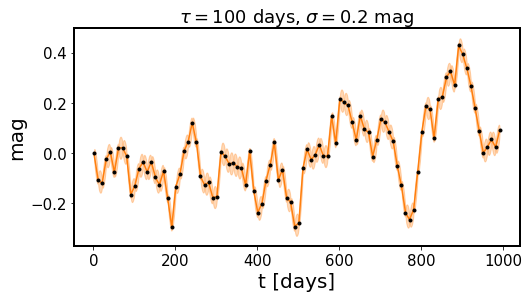

In [499]:



import celerite
import numpy as np
import matplotlib.pyplot as plt
from celerite import terms

tau_in = 100
sigma_in = 0.2 
yerr =  0.001
length = 10  # lc length in terms of timescale 
delta_time = 10

t_min = 1
t_max = t_min + length*tau_in

Npts= int(np.floor((t_max - t_min) / delta_time))
# we determine number of points by responding to the delta_time chosen...
regular_grid = True 
if regular_grid : 
    # evenly spaced sampling within the chosen interval 
    print('Using regular sampling')
    t = np.arange(t_min, t_max, dt)
else :
    # random sampling with the chosen number of points ... 
    # The input coordinates must be sorted
    print('Using random sampling')
    t = np.sort(np.random.uniform(t_min, t_max, Npts)) 

SF_inf = sigma_in * np.sqrt(2)
y = sim_DRW_lightcurve(t, SF_inf, tau_in , 0)

sigma_in = SF_inf / np.sqrt(2)
kernel = terms.RealTerm(log_a = 2 * np.log10(sigma) , log_c = np.log10(1/tau))

# call the model 
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)

# print some info 
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
print("parameter_names:\n{0}\n".format(gp.get_parameter_names()))
print("parameter_vector:\n{0}\n".format(gp.get_parameter_vector()))
print("parameter_bounds:\n{0}\n".format(gp.get_parameter_bounds()))


from scipy.optimize import minimize
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

res = gp.get_parameter_dict()
sigma = np.exp(res['kernel:log_a']/2)
tau = 1.0 / np.exp(res['kernel:log_c'])
print("sigma_fit %f,  tau_fit %f"%(sigma,tau))

# plot the prediction 
x = np.linspace(min(t),max(t) , 5000)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

color = "#ff7f0e"
fig,ax = plt.subplots(1,1,figsize=(8,4))
ax.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
ax.plot(x, pred_mean, color=color)
ax.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
ax.set_xlabel('t [days]')
ax.set_ylabel('mag')
ax.set_title(r'$\tau=$'+str(tau_in)+' days, ' + r'$\sigma=$'+str(sigma_in)+' mag')
plt.savefig('../data_products/DRW_simulate_tau_100_sigma_0.2_regular.png', bbox_inches='tight')
#ax.text(0.7*max(t), 0.5*max(y), 'fit')

Repeat fitting 100 times to see whether the fits of the same lightcurve 
are repeatable ... 

Initial log likelihood: 25.328139479233016
parameter_dict:
OrderedDict([('kernel:log_a', -1.3979400086720375), ('kernel:log_c', -2.0)])

parameter_names:
('kernel:log_a', 'kernel:log_c')

parameter_vector:
[-1.39794001 -2.        ]

parameter_bounds:
[(None, None), (None, None)]

      fun: -318.19526869342326
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -9.09494702e-05,  -9.09494702e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 42
      nit: 9
   status: 0
  success: True
        x: array([-3.7096598 , -4.04350595])
sigma_fit 0.156480,  tau_fit 57.025923
Initial log likelihood: 318.19526869342326
parameter_dict:
OrderedDict([('kernel:log_a', -3.7096598016576752), ('kernel:log_c', -4.0435059544622813)])

parameter_names:
('kernel:log_a', 'kernel:log_c')

parameter_vector:
[-3.7096598  -4.04350595]

parameter_bounds:
[(None, None), (None, None)]

      fun: -318.19526869342485
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=f

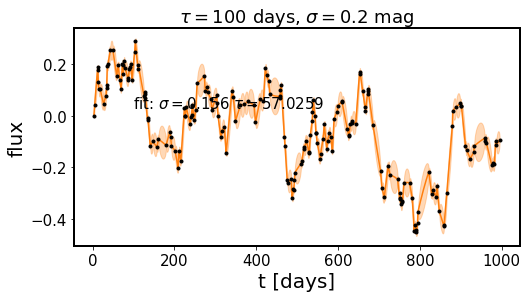

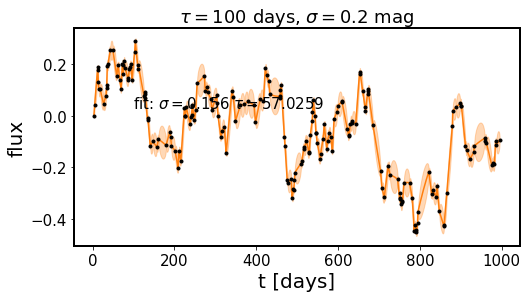

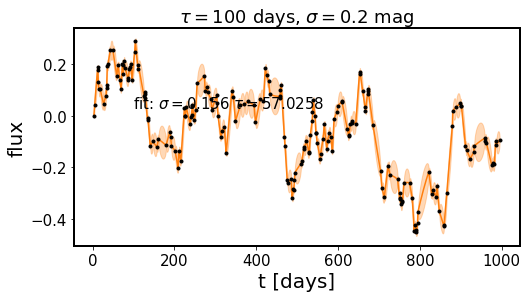

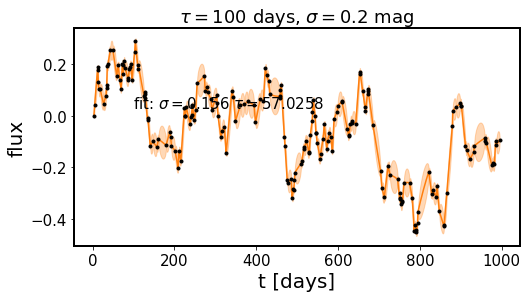

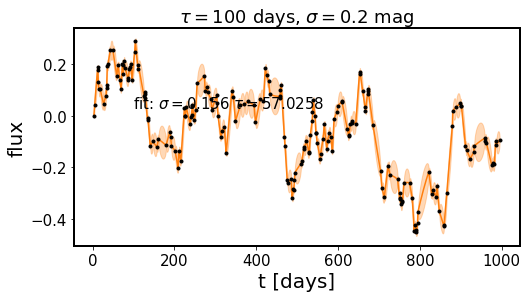

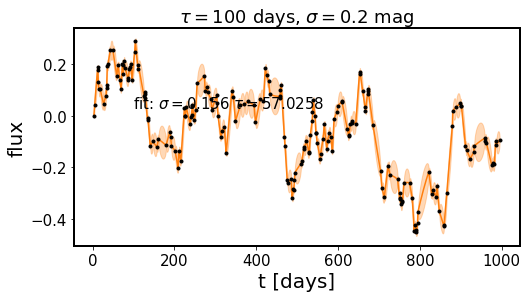

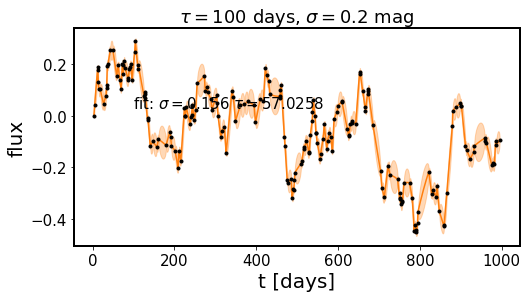

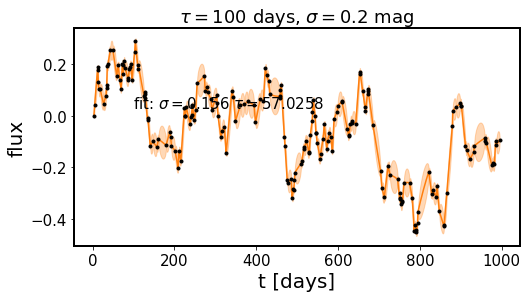

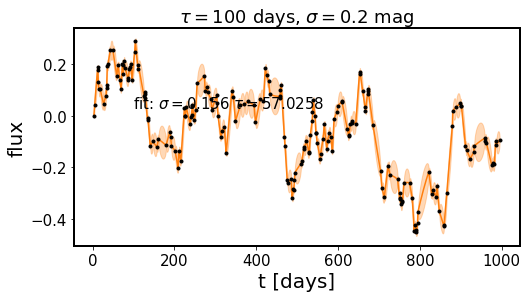

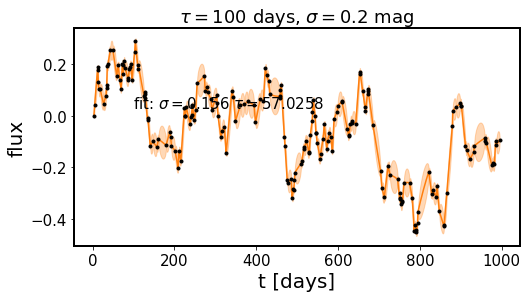

In [29]:

N = 200
t = np.sort(np.random.uniform(1, 1000, N)) # The input coordinates must be sorted
yerr =  0.001 # np.random.uniform(0.004, 0.09, len(t))
sigma_in = 0.2 
tau_in = 100

SF_inf = sigma_in * np.sqrt(2)
y = sim_DRW_lightcurve(t, SF_inf, tau_in , 0)

LC_save[0] = {'t':t, 'y':y, 'yerr':yerr, 'sigma_in':sigma_in, 
              'tau_in':tau_in}

# initialize the kernel ... 
kernel = terms.RealTerm(log_a = 2 * np.log10(sigma_in) , log_c = np.log10(1/tau_in))

# fitting procedure : 

for i in range(10) : 
    # call the model 
    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)

    # print some info 
    print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))
    print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
    print("parameter_names:\n{0}\n".format(gp.get_parameter_names()))
    print("parameter_vector:\n{0}\n".format(gp.get_parameter_vector()))
    print("parameter_bounds:\n{0}\n".format(gp.get_parameter_bounds()))

    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()
    def neg_log_like(params, y, gp):
        gp.set_parameter_vector(params)
        return -gp.log_likelihood(y)


    r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
    gp.set_parameter_vector(r.x)
    print(r)

    res = gp.get_parameter_dict()
    sigma = np.exp(res['kernel:log_a']/2)
    tau = 1.0 / np.exp(res['kernel:log_c'])
    print("sigma_fit %f,  tau_fit %f"%(sigma,tau))

    # plot the prediction 
    x = np.linspace(min(t),max(t) , 5000)
    pred_mean, pred_var = gp.predict(y, x, return_var=True)
    pred_std = np.sqrt(pred_var)

    color = "#ff7f0e"
    fig,ax = plt.subplots(1,1,figsize=(8,4))
    ax.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
    ax.plot(x, pred_mean, color=color)
    ax.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                     edgecolor="none")
    ax.set_xlabel('t [days]')
    ax.set_ylabel('flux')
    ax.set_title(r'$\tau=$'+str(tau_in)+' days, ' + r'$\sigma=$'+str(sigma_in)+' mag')

    ax.text(0.1*max(t), 0.1*max(y), 'fit: '+r'$\sigma=$'+str(sigma)[:5]+
            ' '  +r'$\tau=$'+str(tau)[:7])

Ok : using the same lightcurve,  the fits are consistent with each other.  Now,  what about different realizations of a lightcurve ? 

In [7]:
def sampling(tau_in = 100, length=10, t_min=1, N_pts = None,  dt = 10 , 
                        regular=False, verbose=False):
    ''' A convenience function to return user-defined sampling 
    
    Input: 
    -------
    tau_in : input timescale (default: 100 days )
    length : length in terms of multiples of timescale (default: 10) 
    t_min : starting point of lightcurve (default : 1 )
    N_pts: if provided , then we choose the dt based on the number 
         of points desired. Otherwise the number of points is 
         calculated based on the desired spacing. 
    dt : interval between samplings, if regular = True, then 
        this is the exact interval,  otherwise we divide the 
        light curve length by dt to determine the number 
        of points 
    regular : boolean (True / False). Use regular sampling with dt, 
        or random sampling with Npts = floor(total_timespan / dt) ? 
        
    Returns:
    ---------
    t : sampling times 
    '''
    t_max = t_min + length*tau_in
    if regular : 
        # evenly spaced sampling within the chosen interval 
        if verbose: 
            print('Using regular sampling')
        if N_pts is None : 
            t = np.arange(t_min, t_max, dt)
        else : 
            t = np.linspace(t_min, t_max, N_pts)
    else :
        # random sampling with the chosen number of points ... 
        # The output is sorted
        if verbose: 
            print('Using random sampling')
        if N_pts is None : 
            N_pts= int(np.floor((t_max - t_min) / dt))
        t = np.sort(np.random.uniform(t_min, t_max, N_pts)) 
        
    return t

t = sampling(regular=True)

In [206]:
baseline = 40 # years 
tau_in = 575
l =  (baseline * 365 ) / tau_in
t = sampling(tau_in = tau_in , length = l, t_min=1 , N_pts = 500,  dt = 10 , 
             regular=False, verbose=False)
len(t)

500

## Priors : test whether having a prior makes much difference ... 

In [468]:
import os
import datetime

In [10]:
# Make a todays dir to save the figure ...

outDir = os.path.join(os.getcwd()[:-len('code')],'data_products/Fig_Celerite_simulated_LC',
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
print('We will save this figure in  %s'%outDir)

We will save this figure in  /Users/chris/GradResearch/DRW_Celerite_fitting/data_products/Fig_Celerite_simulated_LC/2017-06-13/


In [9]:
from astropy.utils.console import ProgressBar

In [501]:
ProgressBar?
# https://github.com/BrownDwarf/kinder/blob/master/notebooks/K2c02_AAS230_hack_day.ipynb 

Make 1000 realizations of the same DRW light curve,  fit each time with two ways of choosing the prior, and boundaries on parameters 

In [8]:
t = 400
yerr = np.random.normal(loc = 0, scale = 0.01 , size=4000)

(array([ 1103.,  1042.,   781.,   490.,   306.,   168.,    71.,    25.,
           10.,     4.]),
 array([  2.51605423e-06,   3.69966832e-03,   7.39682058e-03,
          1.10939728e-02,   1.47911251e-02,   1.84882774e-02,
          2.21854296e-02,   2.58825819e-02,   2.95797342e-02,
          3.32768864e-02,   3.69740387e-02]),
 <a list of 10 Patch objects>)

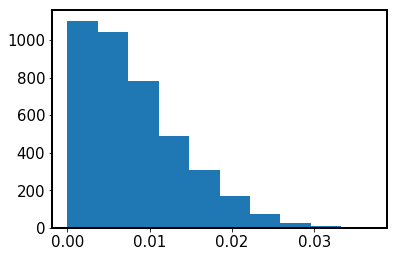

In [12]:

%matplotlib inline
plt.hist(np.abs(yerr))

In [50]:
from itertools import product

# Make 100  realizations of this lightcurve,
# with identical parameters, 
# and make 1 fit each time since as shown above,
# they are completely repeatable ...
# save each lightcurve  by putting it into a dic and then pickling
# the dic with np.save 
# record the results of each fit 

# First set of parameters :  making the light curves in first attempt , 
# that were then  reproduced by Zeljko
# tau_in = 100    ;    sigma_in = 0.2    ;   yerr = 0.001  ,  length = 20   ;  
# dt = 5  ;  N_iterations = 1000   
# sigma_bounds = [0.01, 1.0 ]     ;  tau_bounds = [1 , 10 000]
# This results in a lightcurve that has 400 points 

# We make longer ligh curves   if  we keep  sigma_in,   yerr,  bounds and N_iter 
# unchanged,   but we 
# a) make the baseline longer : keep  dt = 5,  but set length = 100  == setup_1
# b) keep the baseline unchanged,  keep length = 20,  but set dt = 1 == setup_2

# generic setup for input :  doesn't change 
regular_sampling = False
yerr =  0.001 # mags 
tau_in = 100 # days 
length = 100 
sigma_in = 0.2 # mags 
SF_inf = sigma_in * np.sqrt(2)
dt = 5 
N_iterations =  1000

sigma_bounds = [0.01, 1.0]
tau_bounds = [1,10000]

fit_setup = {'sigma_in':sigma_in, 'tau_in':tau_in, 
             'sigma_bounds':sigma_bounds, 'tau_bounds':tau_bounds,
             'yerr' : yerr, 'length':length, 'dt' :dt,
             'regular_sampling':regular_sampling
            }

results = {}
for use_bounds in [False, True]:
    results[use_bounds] = {}
    for prior in ['flat', 'log']:
        results[use_bounds][prior] = {'sigma_fit':np.zeros(N_iterations, dtype=float),
                                      'tau_fit':np.zeros(N_iterations, dtype=float)}
for i in range(N_iterations) :
    # At each iteration we simulate a new DRW with 
    # the same input parameters, so 
    # it makes sense that 
    # all loops over the setup of fitting 
    # procedure : using bounds, or using prior,  are 
    # within here .
    if (i % 100) == 0 : 
        print(i)

    # The input time coordinates must be sorted
    t = sampling(tau_in = tau_in, length=length, regular=regular_sampling, dt=dt)
    y = sim_DRW_lightcurve(t, SF_inf, tau_in , 0)
    #LC_save[i] = {'t':t, 'y':y, 'yerr':yerr} 

    # fitting procedure : 
    # initialize the kernel ... 
    log_a_in = 2 * np.log(sigma_in)
    log_c_in = np.log(1/tau_in)
    kernel = terms.RealTerm(log_a = log_a_in , log_c = log_c_in)

    # call the model 
    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)

    # optimization of the results 
    initial_params = gp.get_parameter_vector()
    for use_bounds, prior in product([True,False], ['flat', 'log']):
        
        if use_bounds : # use some custom boundaries 
            logc_bounds= (np.log(1/max(tau_bounds)), np.log(1/min(tau_bounds)) )
            loga_bounds = (2*np.log(min(sigma_bounds)), 2*np.log(max(sigma_bounds)))
            bounds = [loga_bounds, logc_bounds]
        else : # use the built-in boundaries (-inf : +inf )
            bounds = gp.get_parameter_bounds()
            
        if prior is 'flat' : 
            def neg_log_like(params, y, gp):
                gp.set_parameter_vector(params)
                return -gp.log_likelihood(y)

        if prior is 'log' :
            def neg_log_like(params, y, gp):
                gp.set_parameter_vector(params)
                log_a = params[0]
                log_c = params[1]
                log_prior = 1.5 * log_c - 0.5* log_a + 0.5 *np.log(2) 
                return -gp.log_likelihood(y)  -log_prior
        # do the scipy optimize to find the maximum likelihood estimator 
        # for hyperparameters.... 
        #print('Using %s prior'%prior)
        r = minimize(neg_log_like, initial_params, 
                     method="L-BFGS-B", bounds=bounds, args=(y, gp))
        gp.set_parameter_vector(r.x)
        res = gp.get_parameter_dict()
        sigma_fit = np.exp(res['kernel:log_a']/2)
        tau_fit = 1.0 / np.exp(res['kernel:log_c'])
        results[use_bounds][prior]['sigma_fit'][i] = sigma_fit
        results[use_bounds][prior]['tau_fit'][i] = tau_fit
        
np.save(outDir+'DRW_sim_setup_1.npy',  fit_setup)
np.save(outDir+'DRW_sim_results_1.npy', results)

print('Done')

0
100
200
300
400
500
600
700
800
900
Done


In [13]:
outDir

'/Users/chris/GradResearch/DRW_Celerite_fitting/data_products/Fig_Celerite_simulated_LC/2017-06-14/'

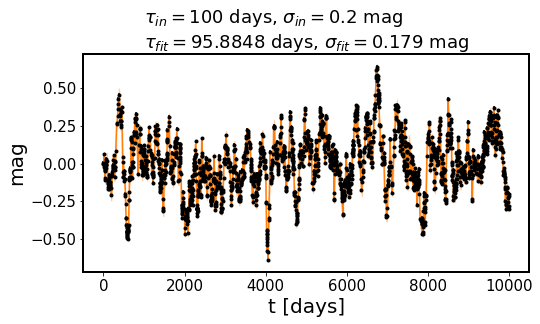

In [45]:
%matplotlib inline

# quantities for plotting ... 
x = np.linspace(min(t),max(t) , 5000)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

color = "#ff7f0e"
fig,ax = plt.subplots(1,1,figsize=(8,4))
ax.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
ax.plot(x, pred_mean, color=color)
ax.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
ax.set_xlabel('t [days]')
ax.set_ylabel('mag')

title = r'$\tau_{in}=$'+str(tau_in)+' days, ' +\
r'$\sigma_{in}=$'+str(sigma_in)+' mag'+'\n'\
       +r'$\tau_{fit}=$'+str(tau_fit)[:7]+' days, '+\
    r'$\sigma_{fit}=$'+str(sigma_fit)[:5]+' mag'

ax.set_title(title,multialignment='left')
#ax.text(0.1*max(t), 0.1*max(y),)
plt.savefig(outDir+'DRW_fit_length-'+str(length)+'_dt-'+str(dt)+'_err_0.001.png', bbox_inches='tight')




In [475]:
# load fit results 
fname = outDir+'test_priors_results.npy'
results= np.load(fname).item() 


In [484]:
len(sig2)

1000

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in log10


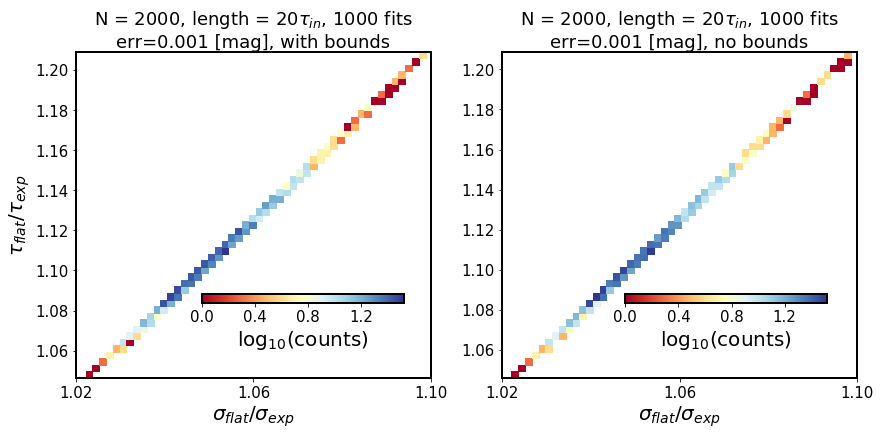

In [38]:
%matplotlib inline
from scipy.stats import binned_statistic_2d


import matplotlib.gridspec as gridspec
fig,ax = plt.subplots(1,2,figsize=(14,6))


i = 0 
x0 = [0.25, 0.67]
for use_bounds in [True,False]: 
    if use_bounds :
        b = 'with bounds'
    else: 
        b = 'no bounds'
    
    sig1 = results[use_bounds]['flat']['sigma_fit']
    sig2 = results[use_bounds]['exp']['sigma_fit']
    
    tau1 = results[use_bounds]['flat']['tau_fit']
    tau2 = results[use_bounds]['exp']['tau_fit']

    x =   sig1 / sig2
    y =  tau1 / tau2
    #xmin, xmax = 1-0.0006, 1+0.0006
    #ymin, ymax = 1.0095, 1.0125
    #m = (xmin < x) * (x < xmax) * (ymin<y) * (y<ymax)

    ax[i].set_title('N = '+str(len(t))+', length = '+str(length)+  r'$ \tau_{in}$,'+' '\
                 +str(len(sig1))+' fits' + '\n' \
                 + 'err='+str(yerr)+' [mag], '+b)
    
    # Plot 2D histogram using pcolor
    stats = binned_statistic_2d(x, y, x, statistic='count', bins=50)
    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
    z_reduce  =  z_sigma
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)
    image = ax[i].pcolormesh(x_edges,y_edges, np.log10(z_masked), cmap=plt.cm.get_cmap('RdYlBu'))
    
    ax[i].set_xlabel(r'$\sigma_{flat}/ \sigma_{exp}$')
    
    cax = fig.add_axes([x0[i], 0.3, 0.2,0.02])
    colorbar = fig.colorbar(image, cax=cax, orientation='horizontal')
    from matplotlib import ticker
    tick_locator = ticker.MaxNLocator(nbins=5)
    colorbar.locator = tick_locator
    colorbar.update_ticks()
    colorbar.set_label(r'$\log_{10}(\mathrm{counts})$')
    
    xticks = ax[i].get_xticks()
    ax[i].set_xticks(xticks[::2])
    
    i += 1 

ax[0].set_ylabel(r'$\tau_{flat} / \tau_{exp}$')

fig.subplots_adjust(wspace=0.2)
plt.savefig(outDir+'DRW_priors_bounds_comp2.png')

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in log10


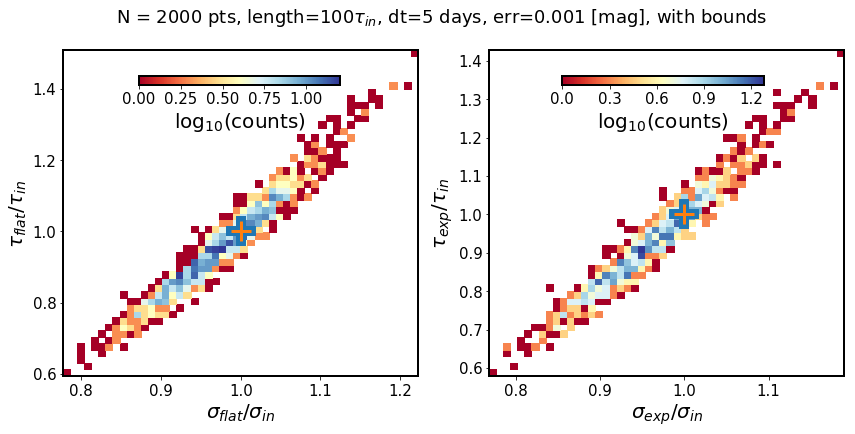

In [51]:
# Make another plot  : showing  the ratios of   tau_fit to  tau_in  ,  and 
# sigma_fit  to sigma_in 


%matplotlib inline
from scipy.stats import binned_statistic_2d
fig,ax = plt.subplots(1,2,figsize=(14,6))


use_bounds  = True
b = 'with bounds'

i = 0 
x0 = [0.2,0.62]
for prior in ['flat', 'log']:
    x =  results[use_bounds][prior]['sigma_fit'] / sigma_in
    y =  results[use_bounds][prior]['tau_fit'] / tau_in

    # Plot 2D histogram using pcolor
    stats = binned_statistic_2d(x, y, x, statistic='count', bins=50)
    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
    z_reduce  =  z_sigma
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)
    image = ax[i].pcolormesh(x_edges,y_edges, np.log10(z_masked), 
                             cmap=plt.cm.get_cmap('RdYlBu'))

    
    cax = fig.add_axes([x0[i], 0.8, 0.2,0.02])
    colorbar = fig.colorbar(image, cax=cax, orientation='horizontal')
    from matplotlib import ticker
    tick_locator = ticker.MaxNLocator(nbins=5)
    colorbar.locator = tick_locator
    colorbar.update_ticks()
    colorbar.set_label(r'$\log_{10}(\mathrm{counts})$')

    #xticks = ax[0].get_xticks()
    #ax[0].set_xticks(xticks[::2])
    ax[i].plot(1,1,marker='+', markersize=30,markerfacecolor='yellow', 
         markeredgewidth=10.0)
    ax[i].plot(1,1,marker='+', markersize=20,markerfacecolor='red', 
         markeredgewidth=3.0)


    i += 1 
    
ax[0].set_xlabel(r'$\sigma_{flat}/ \sigma_{in}$')
ax[0].set_ylabel(r'$\tau_{flat} / \tau_{in}$')
ax[1].set_xlabel(r'$\sigma_{exp}/ \sigma_{in}$')
ax[1].set_ylabel(r'$\tau_{exp} / \tau_{in}$')

fig.suptitle('N = '+str(len(t))+' pts, length='+str(length)+ r'$ \tau_{in}$'+', dt='+\
             str(dt)+' days, '  + '' \
                 + 'err='+str(yerr)+' [mag], '+b, fontsize=18)
    
#fig.text(0.2,0.5,'NEW', fontsize=25)
fig.subplots_adjust(wspace=0.2)
plt.savefig(outDir+'DRW_prior_comp_setup1.png')

In [48]:
fit_setup

{'dt': 1,
 'length': 20,
 'sigma_bounds': [0.01, 1.0],
 'sigma_in': 0.2,
 'tau_bounds': [1, 10000],
 'tau_in': 100,
 'yerr': 0.001}

In [52]:
# load the results ...
fit_setup = np.load(outDir+'DRW_sim_setup_1.npy').item()
results = np.load(outDir+'DRW_sim_results_1.npy').item()



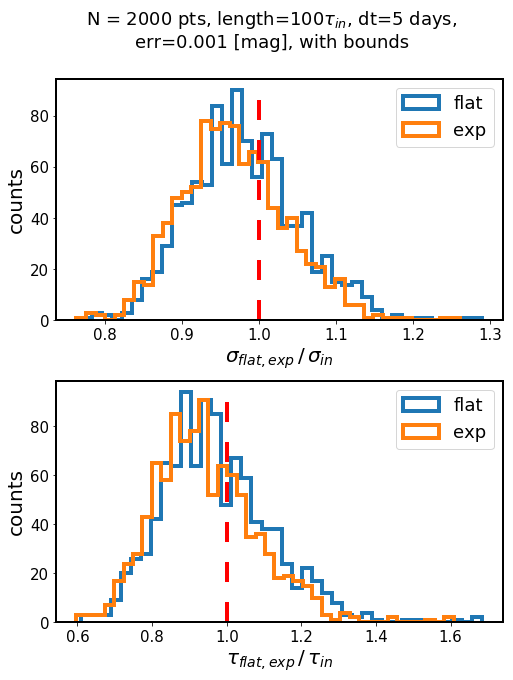

In [53]:
# plot histograms : marginalize along either dimension ... 

fig ,ax  = plt.subplots(2,1,figsize=(8,10))

# two panels  : tau and sigma 

use_bounds  = True
b = 'with bounds'
length = fit_setup['length']
dt = fit_setup['dt']
i = 0 
x0 = [0.2,0.62]
for prior in ['flat', 'exp']:
    x =  results[use_bounds][prior]['sigma_fit'] / sigma_in
    ax[0].hist(x, label = prior, histtype='step', lw=4, bins=40)

    y = results[use_bounds][prior]['tau_fit'] / tau_in
    ax[1].hist(y, label=prior, histtype='step', lw=4, bins=40)

ax[0].set_xlabel(r'$\sigma_{flat,exp}\,/ \,\sigma_{in}$')
ax[1].set_xlabel(r'$\tau_{flat,exp} \,/\, \tau_{in}$')
for i in [0,1]:
    ax[i].legend(fontsize=18)
    ax[i].axvline(1, lw=4, ls='--', c='red', dashes=(5,5))
    ax[i].set_ylabel('counts')
fig.subplots_adjust(hspace=0.25)

fig.suptitle('N = '+str(len(t))+' pts, length='+str(length)+ r'$ \tau_{in}$'+', dt='+\
             str(dt)+' days, \n'  + '' \
                 + 'err='+str(yerr)+' [mag], '+b, fontsize=18)


plt.savefig(outDir + 'DRW_prior_marginalized_set1.png', bbox_inches='tight')
# in each panel , plot histogram of both 

In [442]:
len(y)

200

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in log10


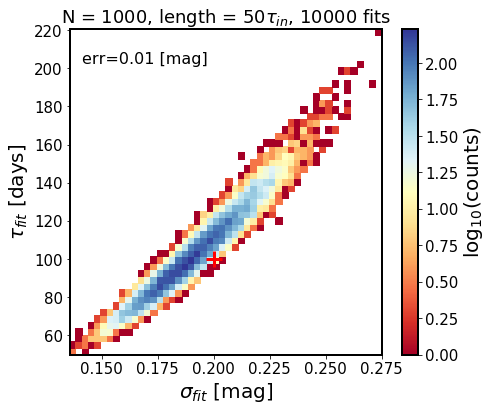

In [127]:
%matplotlib inline
from scipy.stats import binned_statistic_2d

n_fits = len(fit_results['sigma_fit'])
fig,ax = plt.subplots(1,1,figsize=(7,6))
ax.set_title('N = 1000, length = '+str(length)+  r'$ \tau_{in}$,'+' '\
             +str(n_fits)+' fits')

x = fit_results['sigma_fit']
y = fit_results['tau_fit']

# Plot 2D histogram using pcolor
stats = binned_statistic_2d(x, y, x, statistic='count', bins=50)
z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)
image = ax.pcolormesh(x_edges,y_edges, np.log10(z_masked), cmap=plt.cm.get_cmap('RdYlBu'))
colorbar = fig.colorbar(image, orientation='vertical')
colorbar.set_label(r'$\log_{10}(\mathrm{counts})$')
#tick_locator = ticker.MaxNLocator(nbins=5)
#colorbar.locator = tick_locator
#colorbar.update_ticks()
#ax.scatter(,fit_results['tau_fit'], s=5)
ax.scatter(0.2,100, marker='+', s=250, c='red', lw=3) 
# # edgecolor='black', linewidth='3', facecolor='green', hatch='|' 
ax.set_xlabel(r'$\sigma_{fit}$'+' [mag]')
ax.set_ylabel(r'$\tau_{fit}$'+' [days]')
ymax= ax.get_ylim()[0]
xmax = ax.get_xlim()[1]
fig.text(0.15,0.8, 'err='+str(yerr)+' [mag]', fontsize=16)
plt.savefig(outDir+'DRW_simulate_fit_'+str(n_fits)+'_realizations_50_tau_2000pts_e2.png')

Note: here the light curve length is 10 tau.  Anything shorter than that would be likely to 'overestimate tau because there is no information on the timescale of the break'

Note: Chelsea using Kozlowski+2010 method used uniform (flat) priors (see Kozlowski+2010,  Appendix`)

## Chelsea+2011 , Fig.15 

In [187]:
# We reproduce Chelsea'a light curves from her 2011 paper,  which had 
# input tau_in = 575  , SF_inf = 0.2 mag ,  dt = 10 (regular sampling )
# sigma = SF_inf / sqrt(2) = 0.1414 , 
# yerr = np.random.normal(loc = 1, scale = 0.01 , size=len(t))
# I'm not sure about yerr thing... Let's keep it fixed at 0.01 mag for now 
# 

from itertools import product

# Make 100  realizations of this lightcurve,
# with identical parameters, 
# and make 1 fit each time since as shown above,
# they are completely repeatable ...
# save each lightcurve  by putting it into a dic and then pickling
# the dic with np.save 
# record the results of each fit 

regular_sampling = True
yerr =  0.01 # mags 
tau_in = 575 # days 
length = ( 40 * 365 ) / tau_in # we start with length of 40 years, 
# and for shorter ones, we truncate 
SF_inf =  0.2 
sigma_in = SF_inf  / np.sqrt(2)  # mags 
dt = 10  # regular interval in days 
N_iterations =  10000

sigma_bounds = [0.01, 1.0]
tau_bounds = [1,10000]

fit_setup = {'sigma_in':sigma_in, 'tau_in':tau_in, 
             'sigma_bounds':sigma_bounds, 'tau_bounds':tau_bounds,
             'yerr' : yerr, 'length':length, 'dt' :dt,
             'regular_sampling':regular_sampling
            }

results = {}
# use bounds : it makes sense to use them ,
# since using them does not have almost any 
# effect ... 

for length_years in [40,10,3,1] : 
    results[length_years] = {} 
    for prior in ['flat', 'log']:
        results[length_years][prior] =   {
                   'sigma_fit':np.zeros(N_iterations, dtype=float),
                   'tau_fit':np.zeros(N_iterations, dtype=float)
                 }
    
for i in range(N_iterations) :
    # At each iteration we simulate a new DRW with 
    # the same input parameters, so 
    # it makes sense that 
    # all loops over the setup of fitting 
    # procedure : using bounds, or using prior,  are 
    # within here .
    if (i % 100) == 0 : 
        print(i)
    # The input time coordinates must be sorted
    t_full = sampling(tau_in = tau_in, length=length, regular=regular_sampling, dt=dt)
    y_full = sim_DRW_lightcurve(t_full, SF_inf, tau_in , 0)
    #LC_save[i] = {'t':t, 'y':y, 'yerr':yerr} 
     
    # fit four versions : 
    # full 40-year lightcurve,  10-year part, 
    # 3-year, and 1-year chops.
    
    # fitting procedure : 
    # initialize the kernel ... 
    log_a_in = 2 * np.log(sigma_in)
    log_c_in = np.log(1/tau_in)
    kernel = terms.RealTerm(log_a = log_a_in , log_c = log_c_in)
    
    for length_years in [40,10,3,1] : 
        max_ind = int(len(t_full)  * (length_years / 40 ))
        t = t_full[:max_ind]
        y = y_full[:max_ind] 
        
        # call the model 
        gp = celerite.GP(kernel, mean=np.mean(y))
        gp.compute(t, yerr)

        # optimization of the results 
        initial_params = gp.get_parameter_vector()
        for prior in ['flat', 'log'] : 
            
            # use custom bounds  : not much 
            # difference wrt built-in bounds 
            # ( i.e. no bounds at all , since 
            # this is - inf : + inf ) 
            loga_bounds = (2*np.log(min(sigma_bounds)), 2*np.log(max(sigma_bounds)))
            logc_bounds= (np.log(1/max(tau_bounds)), np.log(1/min(tau_bounds)) )
            bounds = [loga_bounds, logc_bounds]
    
            # but try fitting with and without prior to see if there is 
            # any difference... 
            if prior is 'flat' : 
                def neg_log_like(params, y, gp):
                    gp.set_parameter_vector(params)
                    return -gp.log_likelihood(y)

            if prior is 'log' :
                def neg_log_like(params, y, gp):
                    gp.set_parameter_vector(params)
                    log_a = params[0]
                    log_c = params[1]
                    log_prior = 1.5 * log_c - 0.5* log_a + 0.5 *np.log(2) 
                    return -gp.log_likelihood(y)  -log_prior
            # do the scipy optimize to find the maximum likelihood estimator 
            # for hyperparameters.... 
            r = minimize(neg_log_like, initial_params, 
                         method="L-BFGS-B", bounds=bounds, args=(y, gp))
            gp.set_parameter_vector(r.x)
            res = gp.get_parameter_dict()
            sigma_fit = np.exp(res['kernel:log_a']/2)
            tau_fit = 1.0 / np.exp(res['kernel:log_c'])
            results[length_years][prior]['sigma_fit'][i] = sigma_fit
            results[length_years][prior]['tau_fit'][i] = tau_fit
        
np.save(outDir+'DRW_sim_setup_Chelsea.npy',  fit_setup)
np.save(outDir+'DRW_sim_results_Chelsea.npy', results)

print('Done')

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
Done


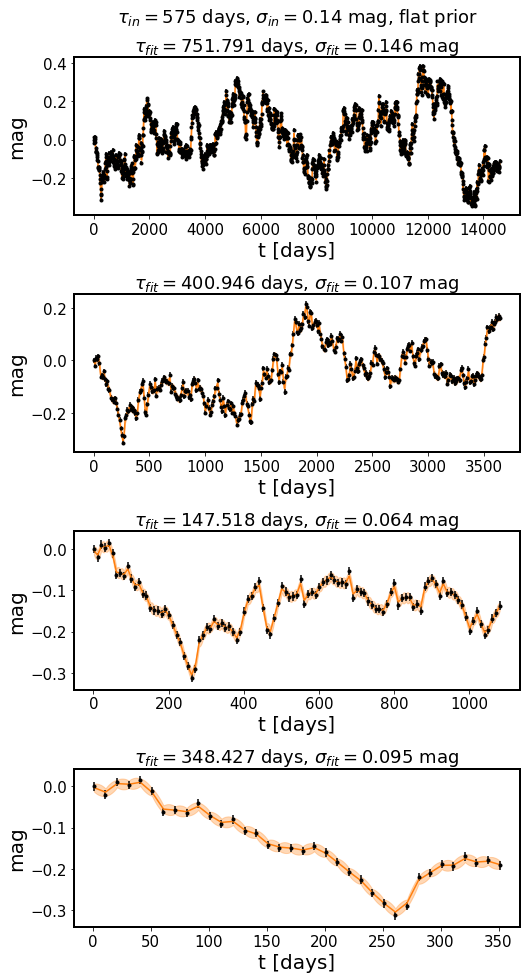

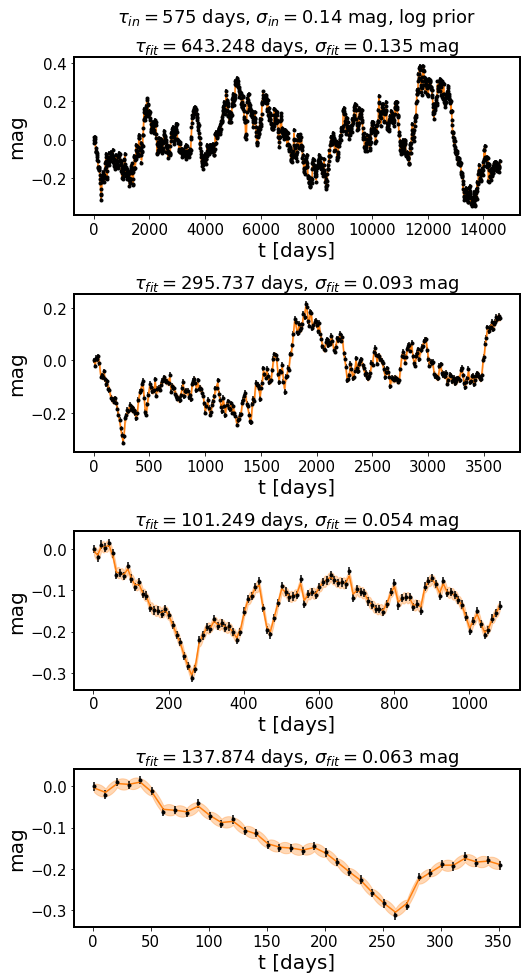

In [70]:
%matplotlib inline

# Make just one light curve :  all setup as above ... 
# The input time coordinates must be sorted
t_full = sampling(tau_in = tau_in, length=length, regular=regular_sampling, dt=dt)
y_full = sim_DRW_lightcurve(t_full, SF_inf, tau_in , 0)

# fitting procedure : 
# initialize the kernel ... 
log_a_in = 2 * np.log(sigma_in)
log_c_in = np.log(1/tau_in)
kernel = terms.RealTerm(log_a = log_a_in , log_c = log_c_in)

for prior in ['flat', 'log'] :
    i = 0 
    # Print lc and example predictions... 
    fig, ax = plt.subplots(4,1,figsize=(8,16))
    for length_years in [40,10,3,1] : 
        max_ind = int(len(t_full)  * (length_years / 40 ))
        t = t_full[:max_ind]
        y = y_full[:max_ind] 

        # call the model 
        gp = celerite.GP(kernel, mean=np.mean(y))
        gp.compute(t, yerr)

        # optimization of the results 
        initial_params = gp.get_parameter_vector()

        # use custom bounds  : not much 
        # difference wrt built-in bounds 
        # ( i.e. no bounds at all , since 
        # this is - inf : + inf ) 
        loga_bounds = (2*np.log(min(sigma_bounds)), 2*np.log(max(sigma_bounds)))
        logc_bounds= (np.log(1/max(tau_bounds)), np.log(1/min(tau_bounds)) )
        bounds = [loga_bounds, logc_bounds]

        # but try fitting with and without prior to see if there is 
        # any difference... 
        if prior is 'flat' : 
            def neg_log_like(params, y, gp):
                gp.set_parameter_vector(params)
                return -gp.log_likelihood(y)

        if prior is 'log' :
            def neg_log_like(params, y, gp):
                gp.set_parameter_vector(params)
                log_a = params[0]
                log_c = params[1]
                log_prior = 1.5 * log_c - 0.5* log_a + 0.5 *np.log(2) 
                return -gp.log_likelihood(y)  -log_prior
        # do the scipy optimize to find the maximum likelihood estimator 
        # for hyperparameters.... 
        r = minimize(neg_log_like, initial_params, 
                     method="L-BFGS-B", bounds=bounds, args=(y, gp))
        gp.set_parameter_vector(r.x)
        res = gp.get_parameter_dict()
        sigma_fit = np.exp(res['kernel:log_a']/2)
        tau_fit = 1.0 / np.exp(res['kernel:log_c'])

        # quantities for plotting ... 
        x = np.linspace(min(t),max(t) , 5000)
        pred_mean, pred_var = gp.predict(y, x, return_var=True)
        pred_std = np.sqrt(pred_var)

        color = "#ff7f0e"
        ax[i].errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
        ax[i].plot(x, pred_mean, color=color)
        ax[i].fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                         edgecolor="none")
        ax[i].set_xlabel('t [days]')
        ax[i].set_ylabel('mag')
        ax[i].set_title(r'$\tau_{fit}=$'+str(tau_fit)[:7]+' days, '+\
        r'$\sigma_{fit}=$'+str(sigma_fit)[:5]+' mag', multialignment='left')
        i += 1 
    fig.subplots_adjust(hspace=0.5)
    fig.text(0.2,0.91, 
             r'$\tau_{in}=$'+str(tau_in)+' days, ' +\
        r'$\sigma_{in}=$'+str(sigma_in)[:4]+' mag, '+ prior+ ' prior', fontsize=18)
    plt.savefig(outDir+'DRW_Chelsea_multiyears_'+prior+\
                '_prior.png', bbox_inches='tight')






In [84]:
results[1]['flat']

{'sigma_fit': array([ 0.08775453,  0.0704652 ,  0.0482543 ,  0.03436988,  0.06161924,
         0.01954154,  0.05512382,  0.22429768,  0.03310783,  0.03616651,
         0.03673503,  0.06246591,  0.03565384,  0.07276336,  0.07554214,
         0.02420608,  0.05813772,  0.12473496,  0.12000157,  0.05621505,
         0.08539913,  0.03841939,  0.04320747,  0.0964991 ,  0.02365341,
         0.03226309,  0.0376796 ,  0.06091449,  0.09915569,  0.06685187,
         0.03493486,  0.03137698,  0.10562903,  0.03278909,  0.04409595,
         0.06460145,  0.05729534,  0.04972264,  0.04645847,  0.0485216 ,
         0.05689687,  0.02652788,  0.04247562,  0.06971538,  0.07563911,
         0.04342485,  0.07096029,  0.04545183,  0.03320234,  0.04238286,
         0.06361524,  0.04296635,  0.07272987,  0.06901404,  0.06403401,
         0.08293169,  0.03711709,  0.03463606,  0.04946964,  0.06384363,
         0.05555804,  0.07453362,  0.06132106,  0.03071242,  0.07157163,
         0.05965007,  0.03483562,  0.0

SF_inf = 0.20
tau_in = 575.00
sigma_in =SF_inf / sqrt(2) =  0.1414
K_in = tau * sqrt(SF_inf) = 115.000
sigma_hat_in = sigma * sqrt(2 / tau) = 0.00834


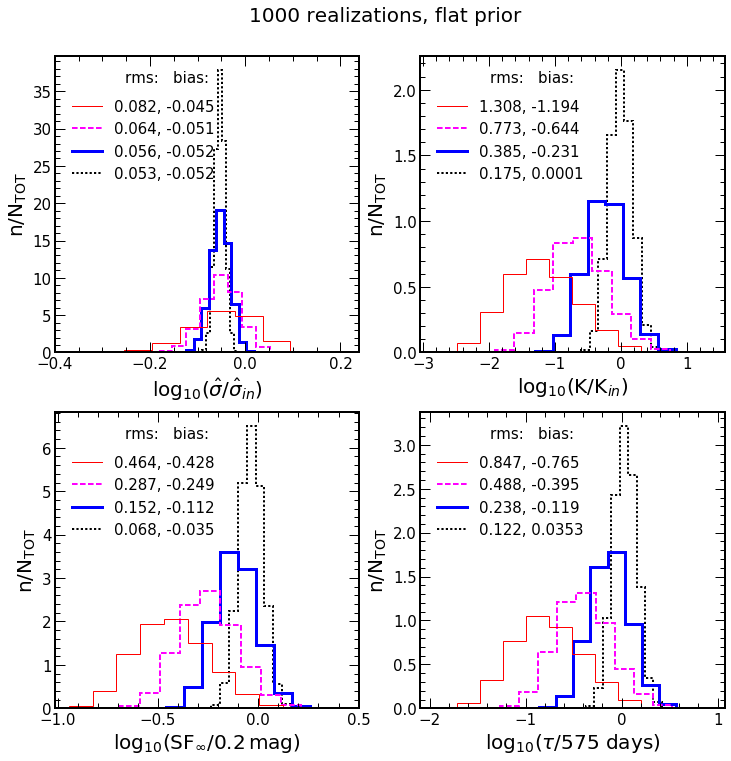

In [259]:
%matplotlib inline
from matplotlib.ticker import AutoMinorLocator
# Plot the figure ...

Dir = '../data_products/Fig_Celerite_simulated_LC/2017-06-14/'
results = np.load(Dir+'DRW_sim_results_Chelsea.npy').item()
print('SF_inf = %.2f'%SF_inf)
print('tau_in = %.2f'%tau_in)
print('sigma_in =SF_inf / sqrt(2) =  %.4f'%sigma_in)
K_in = tau_in * SF_inf
print('K_in = tau * sqrt(SF_inf) = %.3f'% K_in)
sigma_hat_in = sigma_in * np.sqrt(2 / tau_in)
print('sigma_hat_in = sigma * sqrt(2 / tau) = %.5f'%sigma_hat_in)

# Four panels : 

prior = 'flat' #'log'

# initialize the plotting space 
fig,axs = plt.subplots(2,2,figsize=(12,12))

suptitle = str(N_iterations)+' realizations, '+prior+ ' prior'
fig.text(0.35,0.92, suptitle, fontsize=20)
ax = np.ravel(axs)


# dotted and dashed have the same linewidth, 
# but the solid line for 10 years is thick, 
 # and for 1 year is thin 
ls_dic = {40:'dotted', 10:'solid', 3 :'dashed' , 1:'solid' }
lw_dic = {40:2,        10:3,       3: 2 ,        1:1  }
color_dic = {40: 'black', 10:'blue',  3:'magenta', 1:'red' }

ax_legend_handles = {0:[], 1:[], 2:[], 3:[]}

for length_years in [40,10,3,1] : 

    # fitted quantities : sigma , tau 
    tau_fit = results[length_years][prior]['tau_fit']
    sigma_fit = results[length_years][prior]['sigma_fit']

    # derived quantities : sigma_hat,  SF_inf , K 
    sigma_hat_fit = sigma_fit * np.sqrt(2 / tau_fit)
    SF_inf_fit = sigma_fit * np.sqrt(2)
    K_fit = tau_fit * SF_inf_fit
    
    # 0 : upper- left  , 1: upper-right  ,  2: bottom-left 
    # 3 : bottom-right 
    if prior is 'log' : 
        x = np.log10(sigma_hat_fit / sigma_hat_in)
        mask = (-0.22 < x)*( x<0.15)
        
        x_values_dic = {0:x[mask], 
                        1:np.log10(K_fit  / K_in), 
                        2:np.log10(SF_inf_fit / SF_inf), 
                        3:np.log10(tau_fit/ tau_in) 
                        }
    else: 
         x_values_dic = {0:np.log10(sigma_hat_fit / sigma_hat_in), 
                        1:np.log10(K_fit  / K_in), 
                        2:np.log10(SF_inf_fit / SF_inf), 
                        3:np.log10(tau_fit/ tau_in) 
                        }
    
    for i in range(len(ax)):
        x = x_values_dic[i]
        rms  = np.sqrt(np.mean(np.square(x)))
        bias = np.mean(x)
        ax[i].hist(x, histtype='step', ls = ls_dic[length_years],
                   lw=lw_dic[length_years], 
                   color = color_dic[length_years], 
                   normed=True)
        # need to make a line object to 
        # avoid getting a legend with a box ... 
        # https://matplotlib.org/users/legend_guide.html#plotting-guide-legend 
        line = mlines.Line2D([], [], color=color_dic[length_years],lw=lw_dic[length_years], 
                        ls = ls_dic[length_years],label=str(rms)[:5]+', '+str(bias)[:6])
        ax_legend_handles[i].append(line)
    
        
# set labels,  ticks, etc : need to do only once ... 
xlabel_dic = {0:r'$\log_{10}{(\hat{\sigma} / \hat{\sigma}_{in})}$',
              1:r'$\log_{10}{(\mathrm{K}/\mathrm{K}_{in})}$',
              2:r'$\log_{10}{(\mathrm{SF}_{\infty} / 0.2\, \mathrm{mag})}$',
              3:r'$\log_{10}{(\tau / 575\,\, \mathrm{days})}$'
             }

for i in range(len(ax)):
    ax[i].set_xlabel(xlabel_dic[i])
    ax[i].set_ylabel(r'$\mathrm{n} / \mathrm{N}_{\mathrm{TOT}}$')
     # make ticks into the axis, longer and thicker... 
    minorLocator = AutoMinorLocator()
    ax[i].xaxis.set_minor_locator(minorLocator)
    minorLocator = AutoMinorLocator()
    ax[i].yaxis.set_minor_locator(minorLocator)

    ax[i].tick_params(which='both', direction='in', width='1')
    ax[i].tick_params(which='major', length=10)
    ax[i].tick_params(which='minor', length=5, color='black' ) 
    ax[i].yaxis.set_ticks_position('both')
    ax[i].xaxis.set_ticks_position('both')
    ax[i].legend(loc='upper left', handles = ax_legend_handles[i][::-1], frameon=False,
                bbox_to_anchor=(0.01, 0.9), fontsize=15)
    ax[i].text(0.23, 0.91, 'rms:   bias:',transform=ax[i].transAxes, fontsize=15)

if prior  is 'log':
    ax[0].set_xlim(-0.22,0.15)
    ax[1].set_xlim(-2.5,1)
    ax[3].set_xlim(-2.5,1)
plt.savefig(outDir + 'MacLeod_2011_Fig_15_'+prior+'.png', bbox_inches='tight')

In [179]:
min(x_values_dic[0])

-0.27240362781915101

## Chelsea Fig.15 : modified versions

In [227]:
# Make a todays dir to save the figure ...

outDir = os.path.join(os.getcwd()[:-len('code')],'data_products/Fig_Celerite_simulated_LC',
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
print('We will save this figure in  %s'%outDir)

We will save this figure in  /Users/chris/GradResearch/DRW_Celerite_fitting/data_products/Fig_Celerite_simulated_LC/2017-06-15/


Now instead of making a 40-year long lightcurve sampled at regular 10 day intervals, we want to :
      
   a)  make a 40-year long light curve,  and versions that have increasingly larger number of points (i.e. half the dt of the previous one ), but fixed baseline
    
   b)  make a 40-year long ligth curve, and versions where we increase the baseline , but keep the number of points fixed 

Ad  a)  keep length at 40 years, and then increase the number of points. Initially , with dt=10, we have N_start = 1460 points. Then set N_pts = 2 \* N_start,   4 \* N_start,  8 * N_start, effectively making the sampling more dense at each realization.   

In [261]:
# We reproduce Chelsea'a light curves from her 2011 paper,  which had 
# input tau_in = 575  , SF_inf = 0.2 mag ,  dt = 10 (regular sampling )
# sigma = SF_inf / sqrt(2) = 0.1414 , 
# yerr = np.random.normal(loc = 1, scale = 0.01 , size=len(t))
# I'm not sure about yerr thing... Let's keep it fixed at 0.01 mag for now 
# 

from itertools import product

# Make 100  realizations of this lightcurve,
# with identical parameters, 
# and make 1 fit each time since as shown above,
# they are completely repeatable ...
# save each lightcurve  by putting it into a dic and then pickling
# the dic with np.save 
# record the results of each fit 

regular_sampling = True
yerr =  0.01 # mags 

tau_in = 575 # days 
length = ( 40 * 365 ) / tau_in # we start with length of 40 years, 
# and fix at it 
#dt = 10  # regular interval in days 
N_pts = 1460 # to start with 
# and for shorter ones, we truncate 
SF_inf =  0.2 
sigma_in = SF_inf  / np.sqrt(2)  # mags 

N_iterations =  1000

sigma_bounds = [0.01, 1.0]
tau_bounds = [1,10000]

fit_setup = {'sigma_in':sigma_in, 'tau_in':tau_in, 
             'sigma_bounds':sigma_bounds, 'tau_bounds':tau_bounds,
             'yerr' : yerr, 'length':length, 'N_pts' :N_pts,
             'regular_sampling':regular_sampling
            }

results = {}
for factor  in [1,2,4,8] : 
    results[factor] = {} 
    for prior in ['flat']:
        results[factor][prior] =   {
                   'sigma_fit':np.zeros(N_iterations, dtype=float),
                   'tau_fit':np.zeros(N_iterations, dtype=float)
                 }
    
for i in range(N_iterations) :
    # At each iteration we simulate a new DRW with 
    # the same input parameters, so 
    # it makes sense that 
    # all loops over the setup of fitting 
    # procedure : using bounds, or using prior,  are 
    # within here .
    if (i % 100) == 0 : 
        print(i)
        
    # fitting procedure : 
    # initialize the kernel ... 
    log_a_in = 2 * np.log(sigma_in)
    log_c_in = np.log(1/tau_in)
    kernel = terms.RealTerm(log_a = log_a_in , log_c = log_c_in)
        
    # Test four different numbers of points per lightcurve ...     
    for factor in [1,2,4,8] : 
        t = sampling(tau_in = tau_in, length=length, 
                     regular=regular_sampling, 
                     N_pts=N_pts * factor)
        y = sim_DRW_lightcurve(t, SF_inf, tau_in , 0)

        # call the model 
        gp = celerite.GP(kernel, mean=np.mean(y))
        gp.compute(t, yerr)

        # optimization of the results 
        initial_params = gp.get_parameter_vector()
        prior = 'flat' 
        # use custom bounds  : not much 
        # difference wrt built-in bounds 
        # ( i.e. no bounds at all , since 
        # this is - inf : + inf ) 
        loga_bounds = (2*np.log(min(sigma_bounds)), 2*np.log(max(sigma_bounds)))
        logc_bounds = (np.log(1/max(tau_bounds)), np.log(1/min(tau_bounds)) )
        bounds = [loga_bounds, logc_bounds]
        if prior is 'flat' : 
            def neg_log_like(params, y, gp):
                gp.set_parameter_vector(params)
                return -gp.log_likelihood(y)

        # do the scipy optimize to find the maximum likelihood estimator 
        # for hyperparameters.... 
        r = minimize(neg_log_like, initial_params, 
                     method="L-BFGS-B", bounds=bounds, args=(y, gp))
        gp.set_parameter_vector(r.x)
        res = gp.get_parameter_dict()
        sigma_fit = np.exp(res['kernel:log_a']/2)
        tau_fit = 1.0 / np.exp(res['kernel:log_c'])
        results[factor][prior]['sigma_fit'][i] = sigma_fit
        results[factor][prior]['tau_fit'][i] = tau_fit

name_res = outDir+'DRW_sim_results_Chelsea_npts_test.npy'
name_set = outDir+'DRW_sim_setup_Chelsea_npts_test.npy'
np.save(name_set,  fit_setup)
np.save(name_res, results)

print('Done')
print('\nResults saved as %s'%name_res)
print('\nSimulation setup saved as %s '%name_set)

0
100
200
300
400
500
600
700
800
900
Done
Results saved as /Users/chris/GradResearch/DRW_Celerite_fitting/data_products/Fig_Celerite_simulated_LC/2017-06-15/DRW_sim_results_Chelsea_npts_test.npy
Simuation setup saved as /Users/chris/GradResearch/DRW_Celerite_fitting/data_products/Fig_Celerite_simulated_LC/2017-06-15/DRW_sim_setup_Chelsea_npts_test.npy 


For each light curve sampling density (since baseline is fixed, we just increase the number of points ), make an illustration of fit 

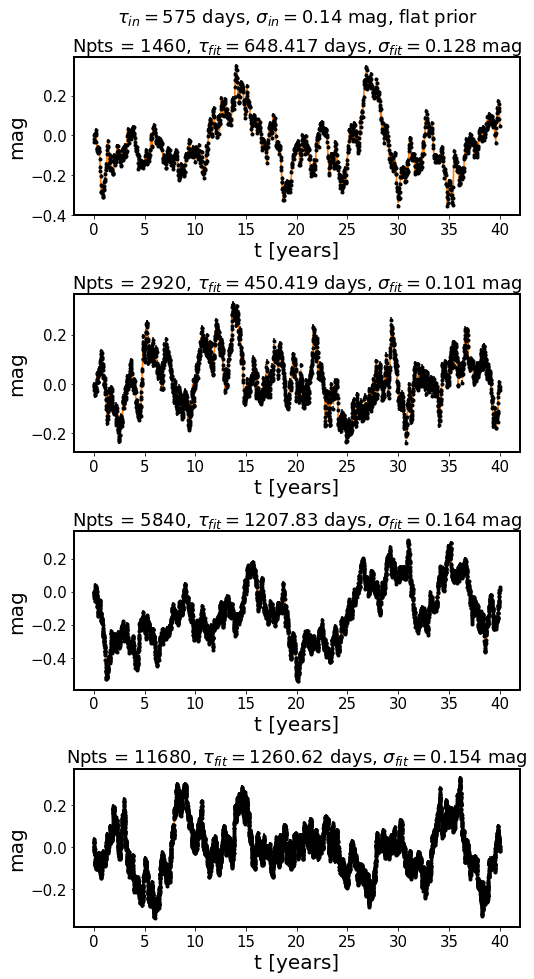

In [266]:
%matplotlib inline

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)
        
# fitting procedure : 
# initialize the kernel ... 
log_a_in = 2 * np.log(sigma_in)
log_c_in = np.log(1/tau_in)
kernel = terms.RealTerm(log_a = log_a_in , log_c = log_c_in)
tau_in = 575
N_pts = 1460
length = (40  * 365 / tau_in)
regular_sampling = True
prior = 'flat'
i = 0 
# Print lc and example predictions... 
fig, ax = plt.subplots(4,1,figsize=(8,16))
for factor in [1,2,4,8] : 
    t = sampling(tau_in = tau_in, length=length, 
                 regular=regular_sampling, 
                 N_pts=N_pts * factor)
    y = sim_DRW_lightcurve(t, SF_inf, tau_in , 0)

    # call the model 
    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)

    # optimization of the results 
    initial_params = gp.get_parameter_vector()

    # use custom bounds  : not much 
    # difference wrt built-in bounds 
    # ( i.e. no bounds at all , since 
    # this is - inf : + inf ) 
    loga_bounds = (2*np.log(min(sigma_bounds)), 2*np.log(max(sigma_bounds)))
    logc_bounds= (np.log(1/max(tau_bounds)), np.log(1/min(tau_bounds)) )
    bounds = [loga_bounds, logc_bounds]

    # do the scipy optimize to find the maximum likelihood estimator 
    # for hyperparameters.... 
    r = minimize(neg_log_like, initial_params, 
                 method="L-BFGS-B", bounds=bounds, args=(y, gp))
    gp.set_parameter_vector(r.x)
    res = gp.get_parameter_dict()
    sigma_fit = np.exp(res['kernel:log_a']/2)
    tau_fit = 1.0 / np.exp(res['kernel:log_c'])

    # quantities for plotting ... 
    x = np.linspace(min(t),max(t) , 5000)
    pred_mean, pred_var = gp.predict(y, x, return_var=True)
    pred_std = np.sqrt(pred_var)

    color = "#ff7f0e"
    ax[i].errorbar(t/365, y, yerr=yerr, fmt=".k", capsize=0)
    ax[i].plot(x/365, pred_mean, color=color)
    ax[i].fill_between(x/365, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                     edgecolor="none")
    ax[i].set_xlabel('t [years]')
    ax[i].set_ylabel('mag')
    ax[i].set_title('Npts = '+str(N_pts*factor)+', '+\
                    r'$\tau_{fit}=$'+str(tau_fit)[:7]+' days, '+\
                    r'$\sigma_{fit}=$'+str(sigma_fit)[:5]+\
                    ' mag', multialignment='left')
    i += 1 
    
fig.subplots_adjust(hspace=0.5)
fig.text(0.2,0.91, 
         r'$\tau_{in}=$'+str(tau_in)+' days, ' +\
    r'$\sigma_{in}=$'+str(sigma_in)[:4]+' mag, '+ prior+ ' prior', fontsize=18)
plt.savefig(outDir+'DRW_Chelsea_Npts_test_'+prior+\
            '_prior.png', bbox_inches='tight')




SF_inf = 0.20
tau_in = 575.00
sigma_in =SF_inf / sqrt(2) =  0.1414
K_in = tau * sqrt(SF_inf) = 115.000
sigma_hat_in = sigma * sqrt(2 / tau) = 0.00834
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
Saved as /Users/chris/GradResearch/DRW_Celerite_fitting/data_products/Fig_Celerite_simulated_LC/2017-06-15/MacLeod_2011_Fig_15_N_pts_test_flat_prior.png


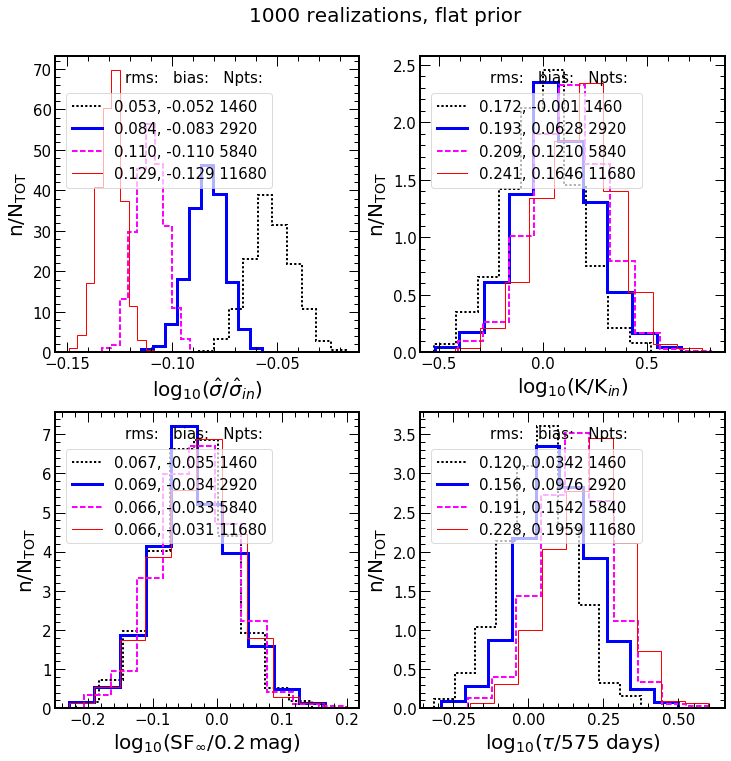

In [283]:
%matplotlib inline
from matplotlib.ticker import AutoMinorLocator
# Plot the figure ...
results = np.load( outDir+'DRW_sim_results_Chelsea_npts_test.npy').item()
print('SF_inf = %.2f'%SF_inf)
print('tau_in = %.2f'%tau_in)
print('sigma_in =SF_inf / sqrt(2) =  %.4f'%sigma_in)
K_in = tau_in * SF_inf
print('K_in = tau * sqrt(SF_inf) = %.3f'% K_in)
sigma_hat_in = sigma_in * np.sqrt(2 / tau_in)
print('sigma_hat_in = sigma * sqrt(2 / tau) = %.5f'%sigma_hat_in)

# Four panels : 

prior = 'flat' #'log'
# initialize the plotting space 
fig,axs = plt.subplots(2,2,figsize=(12,12))

suptitle = str(N_iterations)+' realizations, '+prior+ ' prior'
fig.text(0.35,0.92, suptitle, fontsize=20)
ax = np.ravel(axs)


# dotted and dashed have the same linewidth, 
# but the solid line for 10 years is thick, 
 # and for 1 year is thin 
ls_dic =    {1:'dotted', 2:'solid', 4 :'dashed' , 8:'solid' }
lw_dic =    {1:    2,    2:   3,    4:    2     , 8:   1    }
color_dic = {1: 'black', 2:'blue',  4:'magenta' , 8:'red'   }

ax_legend_handles = {0:[], 1:[], 2:[], 3:[]}

# factor is how many times to increase the 
# number of points ... 
for factor in [1,2,4,8] :

    # fitted quantities : sigma , tau 
    tau_fit   = results[factor][prior]['tau_fit']
    sigma_fit = results[factor][prior]['sigma_fit']

    # derived quantities : sigma_hat,  SF_inf , K 
    sigma_hat_fit = sigma_fit * np.sqrt(2 / tau_fit)
    SF_inf_fit    = sigma_fit * np.sqrt(2)
    K_fit = tau_fit * SF_inf_fit # np.sqrt(sigma_fit) * np.power(2,0.25)
    
    # 0 : upper- left  , 1: upper-right  ,  2: bottom-left 
    # 3 : bottom-right 
    x_values_dic = {0:np.log10(sigma_hat_fit / sigma_hat_in), 
                    1:np.log10(K_fit  / K_in), 
                    2:np.log10(SF_inf_fit / SF_inf), 
                    3:np.log10(tau_fit/ tau_in) 
                    }
    # plot a histogram corresponding to a given 
    # factor in each axis ... 
    for i in range(len(ax)):
        
        x = x_values_dic[i]
        rms  = np.sqrt(np.mean(np.square(x)))
        bias = np.mean(x)
        ax[i].hist(x, histtype='step', ls = ls_dic[factor],
                   lw=lw_dic[factor], 
                   color = color_dic[factor], 
                   normed=True)
        line = mlines.Line2D([], [], color=color_dic[factor],lw=lw_dic[factor], 
                        ls = ls_dic[factor],label=str(rms)[:5]+\
                             ', '+str(bias)[:6]+' ' +str(factor*1460))
        ax_legend_handles[i].append(line)
    
        
# set labels,  ticks, etc : need to do only once ... 
xlabel_dic = {0:r'$\log_{10}{(\hat{\sigma} / \hat{\sigma}_{in})}$',
              1:r'$\log_{10}{(\mathrm{K}/\mathrm{K}_{in})}$',
              2:r'$\log_{10}{(\mathrm{SF}_{\infty} / 0.2\, \mathrm{mag})}$',
              3:r'$\log_{10}{(\tau / 575\,\, \mathrm{days})}$'
             }

for i in range(len(ax)):
    ax[i].set_xlabel(xlabel_dic[i])
    ax[i].set_ylabel(r'$\mathrm{n} / \mathrm{N}_{\mathrm{TOT}}$')
     # make ticks into the axis, longer and thicker... 
    
    minorLocator = AutoMinorLocator(5) # inserts 5 short ticks 
    ax[i].xaxis.set_minor_locator(minorLocator)
    minorLocator = AutoMinorLocator(5)
    ax[i].yaxis.set_minor_locator(minorLocator)
    ax[i].tick_params(which='both', direction='in', width='1')
    ax[i].tick_params(which='major', length=10)
    ax[i].tick_params(which='minor', length=5, color='black' ) 
    ax[i].yaxis.set_ticks_position('both')
    ax[i].xaxis.set_ticks_position('both')
    ax[i].locator_params(nbins=5, axis='x')
    leg = ax[i].legend(loc='upper left', handles = ax_legend_handles[i],
                bbox_to_anchor=(0.01, 0.9), fontsize=15,fancybox=True)
    leg.get_frame().set_alpha(0.7)
    ax[i].text(0.23, 0.91, 'rms:   bias:   Npts:',transform=ax[i].transAxes, fontsize=15)

if prior  is 'log':
    ax[0].set_xlim(-0.22,0.15)
    ax[1].set_xlim(-2.5,1)
    ax[3].set_xlim(-2.5,1)
name = outDir + 'MacLeod_2011_Fig_15_N_pts_test_flat_prior.png'
plt.savefig(name, bbox_inches='tight')
print('Saved as %s'%name)

Why it seems to behave exactly opposite to what we would expect ?  Make more plots ... Specfically , take the longest light curve (with 11680 points), and plot the raw delta_m  vs delta_t,  and the structure function .... 

## Analyzing Structure Function for the npoints experiment

In [3]:
# Make a todays dir to save the figure ...

outDir = os.path.join(os.getcwd()[:-len('code')],'data_products/Fig_Celerite_simulated_LC',
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
print('We will save this figure in  %s'%outDir)

We will save this figure in  /Users/chris/GradResearch/DRW_Celerite/data_products/Fig_Celerite_simulated_LC/2017-06-22/


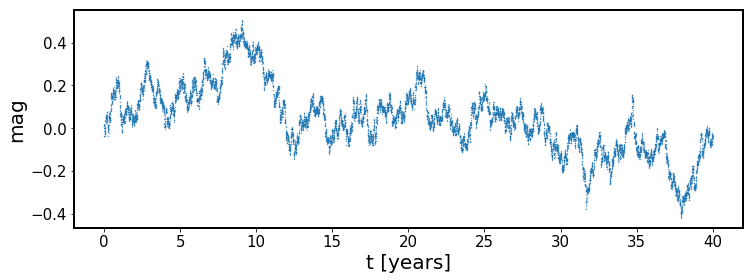

In [91]:
%matplotlib inline

tau_in = 575
N_pts = 1460
SF_inf = 0.2 
yerr = 0.01
length = (40  * 365 / tau_in)
regular_sampling = True
prior = 'flat'


i = 2
# Print lc and example predictions... 

factor = 8 
#for factor in [1,2,4,8] : 
t = sampling(tau_in = tau_in, length=length, 
             regular=regular_sampling, 
             N_pts=N_pts * factor)
y = sim_DRW_lightcurve(t, SF_inf, tau_in , 0)


fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.scatter(t/365, y, s=0.1)
ax.set_xlabel('t [years]')
ax.set_ylabel('mag')
plt.savefig(outDir + 'DRW_npoints_test_lc'+str(i)+'.png', bbox_inches=  'tight')

lc_dic = {'t' :t,  'y':y}
np.save(outDir+'DRW_npoints_test_11680_pts'+str(i), lc_dic)



In [4]:
lc_dic = np.load('../data_products/Fig_Celerite_simulated_LC/2017-06-21/DRW_npoints_test_11680_pts2.npy').item()

In [5]:
t = lc_dic['t']
y = lc_dic['y']

In [9]:
%matplotlib inline 
# Note : for 11600 points this makes arrays with length 6 mln ! 
# It takes almost a minute to make ... 
delta_m = []; delta_t = []
part = 'right'

if part is 'full' :
    y_sec = y;  t_sec = t

if part is 'left' : 
    y_sec = y[:5800]  ;  t_sec = t[:5800]
    
if part is 'right':
    y_sec = y[5800:]  ;  t_sec = t[5800:]
    
for j in range(len(y_sec)-1):
    for k in range(j+1):     
        delta_t.append(t_sec[j+1]-t_sec[k])  # j from 1 and k<j
        delta_m.append((y_sec[k]-y_sec[j+1]))      
#yerr_comb = np.sqrt(yerr**2.0 + yerr**2.0)


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10


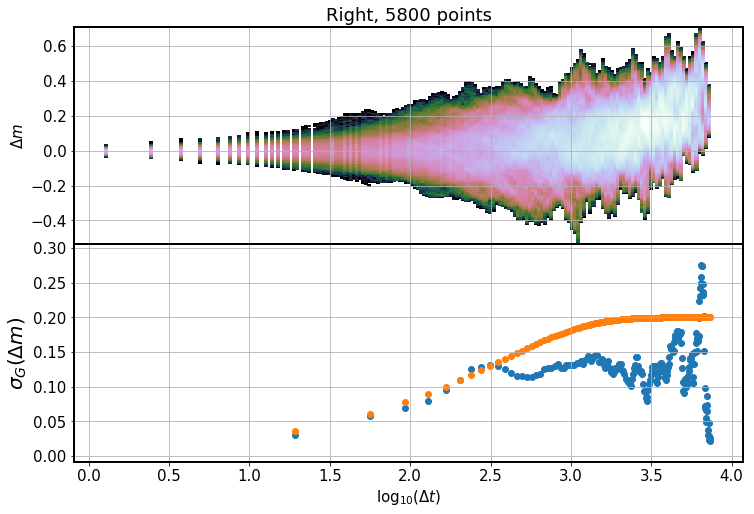

In [10]:
%matplotlib inline
i = 2 
# Plot the raw data... 
import colorcet as cc
from matplotlib.colors import ListedColormap
#cmap = ListedColormap(cc.colorwheel)
cmap = 'cubehelix'

fig,ax = plt.subplots(2,1,figsize=(12,8), sharex=True)

xdata = np.log10(delta_t)
ydata =  delta_m
H, xedges, yedges = np.histogram2d(xdata,ydata, bins=200)
H = np.rot90(H)
H = np.flipud(H)
Hmasked = np.ma.masked_where(H==0,H)

image  = ax[0].pcolormesh(xedges,yedges,np.log10(Hmasked), cmap=cmap)
#colorbar = plt.colorbar(image)

ax[0].set_ylabel(r'$\Delta m$',fontsize=15)
ax[0].grid()

nbins = 200
from scipy.stats import binned_statistic
binned_tau = binned_statistic(delta_t, delta_t, statistic='mean', bins=nbins)

# calculate st.dev.
#rms_std = lambda x : np.std(x)
#stdev_binned = binned_statistic(delta_t, delta_m, statistic = rms_std, 
                                   #   bins=nbins)
# Plot sigmaG  :
sigmaG = lambda x : 0.7414 *(np.percentile(x,75) - np.percentile(x,25))
binned_sigmaG= binned_statistic(delta_t, delta_m, statistic = sigmaG, 
                                      bins=nbins)

# Add theoretical SF .. 
def model_sf(t, sf_inf=0.2, tau = 575):
    br = 1.0-np.exp(-t/tau)
    sf = sf_inf * np.power(br,0.5)
    return sf

ax[1].scatter(np.log10(binned_tau[0]), binned_sigmaG[0])
ax[1].scatter(np.log10(binned_tau[0]), model_sf(binned_tau[0]))
ax[1].grid()
ax[1].set_xlabel(r'$\log_{10}(\Delta t )$', fontsize=15)
ax[1].set_ylabel(r'$\sigma_{G}(\Delta m)$')

fig.subplots_adjust(hspace=0)
if part is 'full' : 
    title = 'Full, 11600 points'
if part is 'left' : 
    title = 'Left, 5800 points'
if part is 'right' : 
    title = 'Right, 5800 points'

ax[0].set_title(title)
plt.savefig(outDir + 'DRW_npoints_test_SF_'+part+'_'+str(i)+'.png')

b) Keep the number of points fixed at 1460,  but make the baseline larger , each time increasing by a factor of 2 .. 

In [241]:
# We reproduce Chelsea'a light curves from her 2011 paper,  which had 
# input tau_in = 575  , SF_inf = 0.2 mag ,  dt = 10 (regular sampling )
# sigma = SF_inf / sqrt(2) = 0.1414 , 
# yerr = np.random.normal(loc = 1, scale = 0.01 , size=len(t))
# I'm not sure about yerr thing... Let's keep it fixed at 0.01 mag for now 
# 

from itertools import product

# Make 100  realizations of this lightcurve,
# with identical parameters, 
# and make 1 fit each time since as shown above,
# they are completely repeatable ...
# save each lightcurve  by putting it into a dic and then pickling
# the dic with np.save 
# record the results of each fit 

regular_sampling = True
yerr =  0.01 # mags 

tau_in = 575 # days 
length = ( 40 * 365 ) / tau_in # we start with length of 40 years, 
#dt = 10  # regular interval in days 
N_pts = 1460 # to start with 
# and for shorter ones, we truncate 
SF_inf =  0.2 
sigma_in = SF_inf  / np.sqrt(2)  # mags 

N_iterations =  1000

sigma_bounds = [0.01, 1.0]
tau_bounds = [1,10000]

fit_setup = {'sigma_in':sigma_in, 'tau_in':tau_in, 
             'sigma_bounds':sigma_bounds, 'tau_bounds':tau_bounds,
             'yerr' : yerr, 'length':length, 'N_pts' :N_pts,
             'regular_sampling':regular_sampling
            }

results = {}
# use bounds : it makes sense to use them ,
# since using them does not have almost any 
# effect ... 

for factor  in [1,2,4,8] : 
    results[factor] = {} 
    for prior in ['flat']:
        results[factor][prior] =   {
                   'sigma_fit':np.zeros(N_iterations, dtype=float),
                   'tau_fit':np.zeros(N_iterations, dtype=float)
                 }
    
for i in range(N_iterations) :
    # At each iteration we simulate a new DRW with 
    # the same input parameters, so 
    # it makes sense that 
    # all loops over the setup of fitting 
    # procedure : using bounds, or using prior,  are 
    # within here .
    if (i % 100) == 0 : 
        print(i)
        
    # fitting procedure : 
    # initialize the kernel ... 
    log_a_in = 2 * np.log(sigma_in)
    log_c_in = np.log(1/tau_in)
    kernel = terms.RealTerm(log_a = log_a_in , log_c = log_c_in)
        
    # Test four different numbers of points per lightcurve ...     
    for factor in [1,2,4,8] : 
        t = sampling(tau_in = tau_in, length=factor*length, 
                     regular=regular_sampling, 
                     N_pts=N_pts )
        y = sim_DRW_lightcurve(t, SF_inf, tau_in , 0)

        # call the model 
        gp = celerite.GP(kernel, mean=np.mean(y))
        gp.compute(t, yerr)

        # optimization of the results 
        initial_params = gp.get_parameter_vector()
        prior = 'flat' 
        # use custom bounds  : not much 
        # difference wrt built-in bounds 
        # ( i.e. no bounds at all , since 
        # this is - inf : + inf ) 
        loga_bounds = (2*np.log(min(sigma_bounds)), 2*np.log(max(sigma_bounds)))
        logc_bounds= (np.log(1/max(tau_bounds)), np.log(1/min(tau_bounds)) )
        bounds = [loga_bounds, logc_bounds]

        if prior is 'flat' : 
            def neg_log_like(params, y, gp):
                gp.set_parameter_vector(params)
                return -gp.log_likelihood(y)

        # do the scipy optimize to find the maximum likelihood estimator 
        # for hyperparameters.... 
        r = minimize(neg_log_like, initial_params, 
                     method="L-BFGS-B", bounds=bounds, args=(y, gp))
        gp.set_parameter_vector(r.x)
        res = gp.get_parameter_dict()
        sigma_fit = np.exp(res['kernel:log_a']/2)
        tau_fit = 1.0 / np.exp(res['kernel:log_c'])
        results[factor][prior]['sigma_fit'][i] = sigma_fit
        results[factor][prior]['tau_fit'][i] = tau_fit

name_res = outDir+'DRW_sim_results_Chelsea_baseline_test.npy'
name_set = outDir+'DRW_sim_setup_Chelsea_baseline_test.npy'
np.save(name_set,  fit_setup)
np.save(name_res, results)

print('Done')
print('Results saved as %s'%name_res)
print('Simuation setup saved as %s '%name_set)

0
100
200
300
400
500
600
700
800
900
Done
Results saved as /Users/chris/GradResearch/DRW_Celerite_fitting/data_products/Fig_Celerite_simulated_LC/2017-06-15/DRW_sim_results_Chelsea_baseline_test.npy
Simuation setup saved as /Users/chris/GradResearch/DRW_Celerite_fitting/data_products/Fig_Celerite_simulated_LC/2017-06-15/DRW_sim_setup_Chelsea_baseline_test.npy 


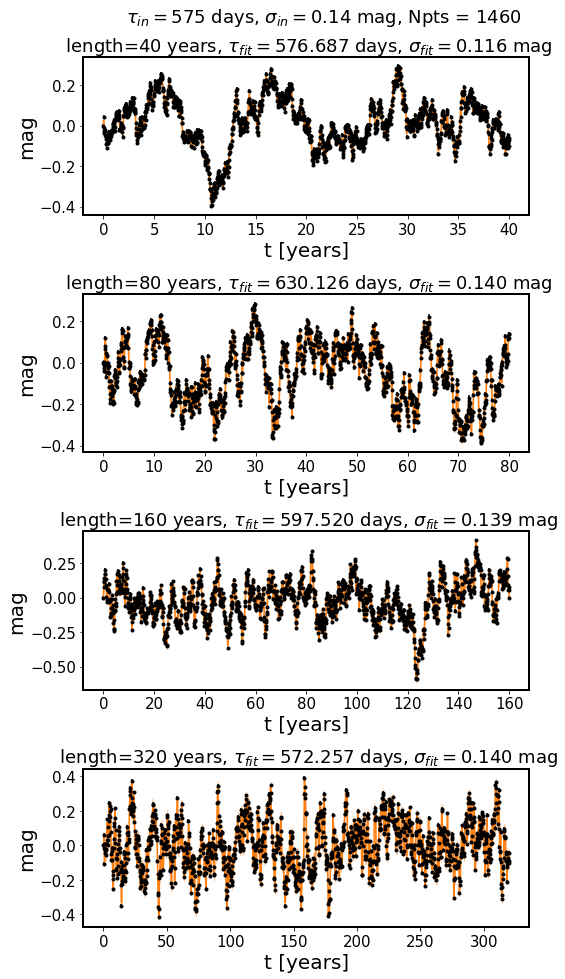

In [255]:
# Plot examples of light curves with increasing baseline,
# but fixed number of points (starting at dt=10  at 40-year lightcurve, i.e.
# N = 1460 )
%matplotlib inline

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)
        
# fitting procedure : 
# initialize the kernel ... 
log_a_in = 2 * np.log(sigma_in)
log_c_in = np.log(1/tau_in)
kernel = terms.RealTerm(log_a = log_a_in , log_c = log_c_in)
tau_in = 575
N_pts = 1460
length = (40  * 365 / tau_in)
regular_sampling = True
prior = 'flat'
i = 0 
# Print lc and example predictions... 
fig, ax = plt.subplots(4,1,figsize=(8,16))
for factor in [1,2,4,8] : 
    t = sampling(tau_in = tau_in, length=factor*length, 
                 regular=regular_sampling, 
                 N_pts=N_pts )
    y = sim_DRW_lightcurve(t, SF_inf, tau_in , 0)

    # call the model 
    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)

    # optimization of the results 
    initial_params = gp.get_parameter_vector()

    # use custom bounds  : not much 
    # difference wrt built-in bounds 
    # ( i.e. no bounds at all , since 
    # this is - inf : + inf ) 
    loga_bounds = (2*np.log(min(sigma_bounds)), 2*np.log(max(sigma_bounds)))
    logc_bounds= (np.log(1/max(tau_bounds)), np.log(1/min(tau_bounds)) )
    bounds = [loga_bounds, logc_bounds]

    # do the scipy optimize to find the maximum likelihood estimator 
    # for hyperparameters.... 
    r = minimize(neg_log_like, initial_params, 
                 method="L-BFGS-B", bounds=bounds, args=(y, gp))
    gp.set_parameter_vector(r.x)
    res = gp.get_parameter_dict()
    sigma_fit = np.exp(res['kernel:log_a']/2)
    tau_fit = 1.0 / np.exp(res['kernel:log_c'])

    # quantities for plotting ... 
    x = np.linspace(min(t),max(t) , 5000)
    pred_mean, pred_var = gp.predict(y, x, return_var=True)
    pred_std = np.sqrt(pred_var)

    color = "#ff7f0e"
    ax[i].errorbar(t/ 365, y, yerr=yerr, fmt=".k", capsize=0)
    ax[i].plot(x/365, pred_mean, color=color)
    ax[i].fill_between(x/365, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                     edgecolor="none")
    ax[i].set_xlabel('t [years]')
    ax[i].set_ylabel('mag')
    ax[i].set_title(' length='+str(factor*40)+' years, '+\
                     r'$\tau_{fit}=$'+str(tau_fit)[:7]+' days, '+\
                     r'$\sigma_{fit}=$'+str(sigma_fit)[:5]+\
                    ' mag', multialignment='left')
    i += 1 
    
fig.subplots_adjust(hspace=0.5)
fig.text(0.2,0.91, 
         r'$\tau_{in}=$'+str(tau_in)+' days, ' +\
    r'$\sigma_{in}=$'+str(sigma_in)[:4]+' mag, '+'Npts = '+str(N_pts), fontsize=18)
plt.savefig(outDir+'DRW_Chelsea_baseline_test_'+prior+\
            '_prior.png', bbox_inches='tight')





SF_inf = 0.20
tau_in = 575.00
sigma_in =SF_inf / sqrt(2) =  0.1414
K_in = tau * sqrt(SF_inf) = 115.000
sigma_hat_in = sigma * sqrt(2 / tau) = 0.00834
Saved as /Users/chris/GradResearch/DRW_Celerite_fitting/data_products/Fig_Celerite_simulated_LC/2017-06-15/MacLeod_2011_Fig_15_baseline_test_flat_prior.png


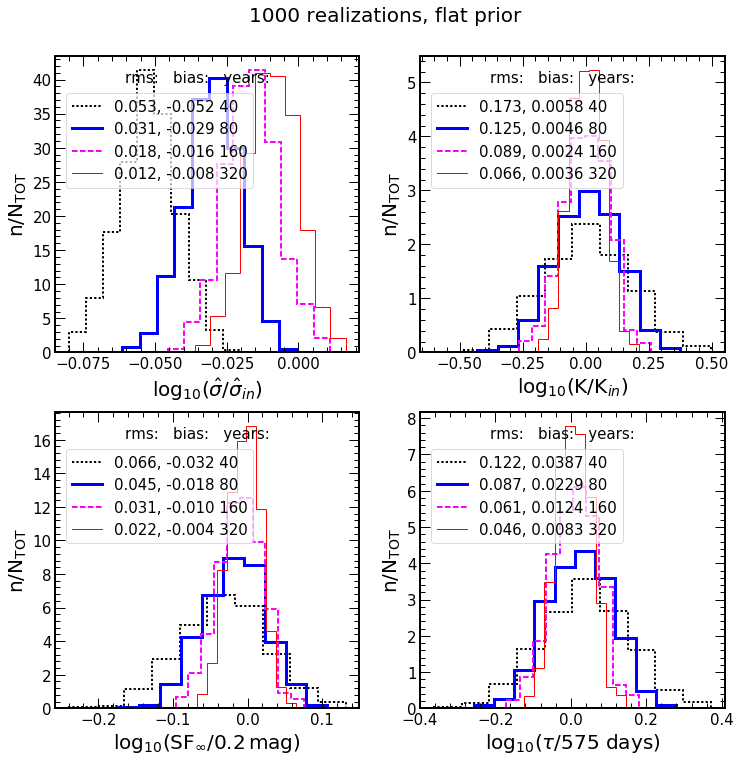

In [286]:
%matplotlib inline
from matplotlib.ticker import AutoMinorLocator
# Plot the figure ...

results = np.load(outDir+'DRW_sim_results_Chelsea_baseline_test.npy').item()
print('SF_inf = %.2f'%SF_inf)
print('tau_in = %.2f'%tau_in)
print('sigma_in =SF_inf / sqrt(2) =  %.4f'%sigma_in)
K_in = tau_in * SF_inf
print('K_in = tau * sqrt(SF_inf) = %.3f'% K_in)
sigma_hat_in = sigma_in * np.sqrt(2 / tau_in)
print('sigma_hat_in = sigma * sqrt(2 / tau) = %.5f'%sigma_hat_in)

# Four panels : 

prior = 'flat' #'log'

# initialize the plotting space 
fig,axs = plt.subplots(2,2,figsize=(12,12))

suptitle = str(N_iterations)+' realizations, '+prior+ ' prior'
fig.text(0.35,0.92, suptitle, fontsize=20)
ax = np.ravel(axs)


# dotted and dashed have the same linewidth, 
# but the solid line for 10 years is thick, 
 # and for 1 year is thin 
ls_dic =    {1:'dotted', 2:'solid', 4 :'dashed' , 8:'solid' }
lw_dic =    {1:2,        2:3,       4: 2 ,        8:1  }
color_dic = {1: 'black', 2:'blue',  4:'magenta',  8:'red' }

ax_legend_handles = {0:[], 1:[], 2:[], 3:[]}

for factor in [1,2,4,8] :

    # fitted quantities : sigma , tau 
    tau_fit = results[factor][prior]['tau_fit']
    sigma_fit = results[factor][prior]['sigma_fit']

    # derived quantities : sigma_hat,  SF_inf , K 
    sigma_hat_fit = sigma_fit * np.sqrt(2 / tau_fit)
    SF_inf_fit = sigma_fit * np.sqrt(2)
    K_fit = tau_fit * SF_inf_fit 
    
    # 0 : upper- left  , 1: upper-right  ,  2: bottom-left 
    # 3 : bottom-right 
    x_values_dic = {0:np.log10(sigma_hat_fit / sigma_hat_in), 
                    1:np.log10(K_fit  / K_in), 
                    2:np.log10(SF_inf_fit / SF_inf), 
                    3:np.log10(tau_fit/ tau_in) 
                    }
    
    for i in range(len(ax)):
        x = x_values_dic[i]
        rms  = np.sqrt(np.mean(np.square(x)))
        bias = np.mean(x)
        ax[i].hist(x, histtype='step', ls = ls_dic[factor],
                   lw=lw_dic[factor], 
                   color = color_dic[factor], 
                   normed=True)
        line = mlines.Line2D([], [], color=color_dic[factor],lw=lw_dic[factor], 
                        ls = ls_dic[factor],label=str(rms)[:5]+', '+\
                             str(bias)[:6]+' '+str(factor*40))
        ax_legend_handles[i].append(line)
    
        
# set labels,  ticks, etc : need to do only once ... 
xlabel_dic = {0:r'$\log_{10}{(\hat{\sigma} / \hat{\sigma}_{in})}$',
              1:r'$\log_{10}{(\mathrm{K}/\mathrm{K}_{in})}$',
              2:r'$\log_{10}{(\mathrm{SF}_{\infty} / 0.2\, \mathrm{mag})}$',
              3:r'$\log_{10}{(\tau / 575\,\, \mathrm{days})}$'
             }

for i in range(len(ax)):
    ax[i].set_xlabel(xlabel_dic[i])
    ax[i].set_ylabel(r'$\mathrm{n} / \mathrm{N}_{\mathrm{TOT}}$')
     # make ticks into the axis, longer and thicker... 
    minorLocator = AutoMinorLocator(5)
    ax[i].xaxis.set_minor_locator(minorLocator)
    minorLocator = AutoMinorLocator(5)
    ax[i].yaxis.set_minor_locator(minorLocator)

    ax[i].tick_params(which='both', direction='in', width='1')
    ax[i].tick_params(which='major', length=10)
    ax[i].tick_params(which='minor', length=5, color='black' ) 
    ax[i].yaxis.set_ticks_position('both')
    ax[i].xaxis.set_ticks_position('both')
    ax[i].locator_params(nbins=5, axis='x')
        
    leg = ax[i].legend(loc='upper left', handles = ax_legend_handles[i],
                bbox_to_anchor=(0.01, 0.9), fontsize=15,fancybox=True)
    leg.get_frame().set_alpha(0.7)
    ax[i].text(0.23, 0.91, 'rms:   bias:   years:',transform=ax[i].transAxes, fontsize=15)

if prior  is 'log':
    ax[0].set_xlim(-0.22,0.15)
    ax[1].set_xlim(-2.5,1)
    ax[3].set_xlim(-2.5,1)
name = outDir + 'MacLeod_2011_Fig_15_baseline_test_flat_prior.png'
plt.savefig(name, bbox_inches='tight')
print('Saved as %s'%name)

## Plotting the SF for the light curves 

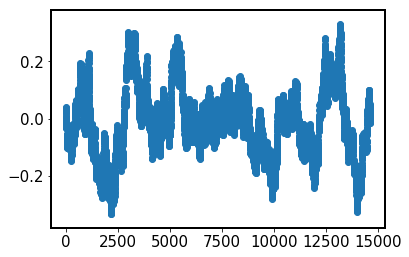

In [299]:
# Take the light curve with 11600 points (the longest), but with baseline 40 years (basic...)
 

In [292]:

# Note : for 11600 points this makes arrays with length 6 mln ! 
# It takes almost a minute to make ... 
delta_m = []; delta_t = []
for j in range(len(y)-1):
    for k in range(j+1):     
        delta_t.append(t[j+1]-t[k])  # j from 1 and k<j
        delta_m.append((y[k]-y[j+1]))      
yerr = 0.01
yerr_comb = np.sqrt(yerr**2.0 + yerr**2.0)

In [294]:
from scipy.stats import binned_statistic
rms_std = lambda x : np.std(x)
nbins = 200
stdev_binned = binned_statistic(delta_t, delta_m, statistic = rms_std, bins=nbins)
binned_tau = binned_statistic(delta_t, delta_t, statistic='mean', bins=nbins)


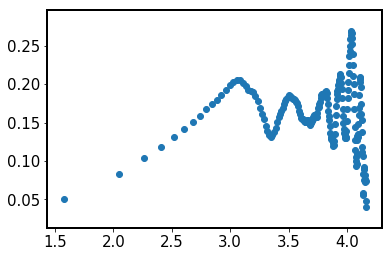

In [297]:
fig,ax = plt.subplots(1,1)
ax.scatter(np.log10(binned_tau[0]),  stdev_binned[0])

## Plotting the log-likelihood space for a given light curve 